In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt comet_ml  # install

import torch
import utils

display = utils.notebook_init()  # checks

from IPython. display import Image, clear_output # to display images

In [ ]:
!pip install roboflow
import os
from roboflow import Roboflow


from roboflow import Roboflow
rf = Roboflow(api_key="bnMyWHZZtfUGoOMVhl5s")
project = rf.workspace("dataset1-30sfw").project("unity-aruco-detection")
version = project.version(1)
dataset = version.download("yolov5")

In [ ]:
!unzip /content/datasets/Unity-AruCo-Detection-1/roboflow.zip -d /content/datasets/Unity-AruCo-Detection-1


In [ ]:
!python yolov5/train.py --img 640 --batch 16 --epochs 20 --data /content/datasets/Unity-AruCo-Detection-1/data.yaml --weights yolov5s.pt


In [ ]:
import matplotlib.pyplot as plt

# Redefining the data with the new results
epochs = list(range(20))  # 0 to 19
mAP50_new = [
    0.413, 0.497, 0.651, 0.759, 0.835, 0.795, 0.941, 0.943, 0.943, 0.958,
    0.956, 0.956, 0.958, 0.958, 0.961, 0.961, 0.966, 0.968, 0.966, 0.967
]
mAP50_95_new = [
    0.139, 0.243, 0.398, 0.448, 0.443, 0.551, 0.668, 0.702, 0.778, 0.799,
    0.769, 0.829, 0.865, 0.883, 0.856, 0.9, 0.903, 0.906, 0.907, 0.916
]
precision_new = [
    0.844, 0.401, 0.625, 0.632, 0.738, 0.66, 0.855, 0.916, 0.876, 0.916,
    0.918, 0.913, 0.919, 0.918, 0.92, 0.919, 0.918, 0.918, 0.919, 0.919
]
recall_new = [
    0.368, 0.756, 0.691, 0.812, 0.881, 0.976, 0.94, 0.982, 0.993, 0.99,
    0.99, 0.983, 0.99, 0.989, 0.986, 0.986, 0.992, 0.99, 0.993, 0.993
]

# Plotting the graph of mAP50, mAP50-95, Precision, and Recall over epochs for the new dataset
plt.figure(figsize=(14, 7))
plt.plot(epochs, mAP50_new, marker='o', linestyle='-', color='blue', label='mAP50')
plt.plot(epochs, mAP50_95_new, marker='v', linestyle='--', color='green', label='mAP50-95')
plt.plot(epochs, precision_new, marker='s', linestyle='-.', color='red', label='Precision')
plt.plot(epochs, recall_new, marker='*', linestyle=':', color='magenta', label='Recall')

plt.title('Model Accuracy Metrics over Epochs (New Data)')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs

In [ ]:
import glob
from IPython.display import Image, display

i = 0
# Choose the correct exp folder - see prev output block
for imageName in glob.glob('/content/yolov5/runs/detect/exp2/*.jpg'):  # assuming PNG
    i += 1

    if i <= 8:  # Display the first 8 images
        display(Image(filename=imageName))
        print("\n")


In [ ]:
!python yolov5/detect.py --weights yolov5/best.pt --img 416 --conf 0.2 --source Unity-AruCo-Detection-1/valid/images --save-txt


Precision-Recall Curve

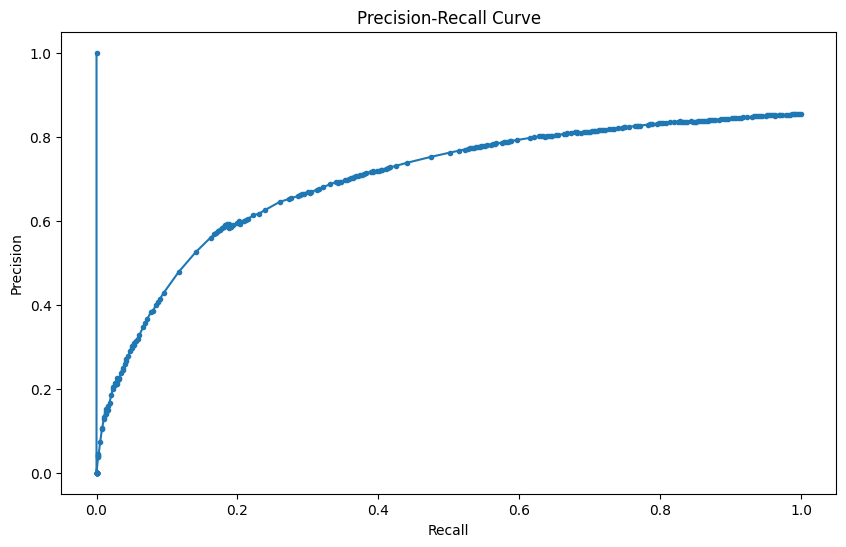

In [ ]:
import glob
import os
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Load ground truth and predicted labels
gt_dir = 'Unity-AruCo-Detection-1/valid/labels/'
pred_dir = 'yolov5/runs/detect/exp4/labels/'

gt_files = glob.glob(os.path.join(gt_dir, '*.txt'))

# Initialize variables to calculate TP, FP, FN for PR curve and confusion matrix
true_labels = []
score_values = []

def load_labels(file_path):
    with open(file_path, 'r') as f:
        labels = [line.strip().split() for line in f.readlines()]
        return [(int(label[0]), float(label[1]), [float(x) for x in label[2:]]) for label in labels]


def calculate_iou(box1, box2):
    # Convert bounding boxes from (center x, center y, width) to (x1, y1, x2, y2)
    x1_min = box1[0] - box1[2] / 2
    y1_min = box1[1] - box1[2] / 2
    x1_max = box1[0] + box1[2] / 2
    y1_max = box1[1] + box1[2] / 2

    x2_min = box2[0] - box2[2] / 2
    y2_min = box2[1] - box2[2] / 2
    x2_max = box2[0] + box2[2] / 2
    y2_max = box2[1] + box2[2] / 2


    # Calculate the intersection area
    inter_area = max(0, min(x1_max, x2_max) - max(x1_min, x2_min)) * max(0, min(y1_max, y2_max) - max(y1_min, y2_min))
    # Calculate the union area
    union_area = (x1_max - x1_min) * (y1_max - y1_min) + (x2_max - x2_min) * (y2_max - y2_min) - inter_area

    return inter_area / union_area if union_area else 0



for gt_file in gt_files:
    base = os.path.basename(gt_file)
    pred_file = os.path.join(pred_dir, base)

    gt_labels = load_labels(gt_file)
    pred_labels = load_labels(pred_file) if os.path.exists(pred_file) else []

    for pred_label in pred_labels:
        pred_box = pred_label[2]  # This should be a list of bounding box coordinates
        score = pred_label[1]

        matched = False
        for gt_label in gt_labels:
            gt_box = gt_label[2]  # This should also be a list of bounding box coordinates

            if calculate_iou(gt_box, pred_box) >= 0.5:
                true_labels.append(1)  # True positive
                matched = True
                break

        if not matched:
            true_labels.append(0)  # False positive

        score_values.append(score)



# Calculate precision and recall for PR curve
precision, recall, thresholds = precision_recall_curve(true_labels, score_values)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()


In [ ]:
# Initialize variables for TP, FP, FN
tp, fp, fn = 0, 0, 0

for gt_file in gt_files:
    base = os.path.basename(gt_file)
    pred_file = os.path.join(pred_dir, base)

    gt_labels = load_labels(gt_file)
    pred_labels = load_labels(pred_file) if os.path.exists(pred_file) else []

    matched_gt = set()  # Track which ground truth labels are matched

    for pred_label in pred_labels:
        pred_box = pred_label[2]  # This should be a list of bounding box coordinates
        score = pred_label[1]

        matched = False
        for gt_label in gt_labels:
            gt_box = gt_label[2]  # This should also be a list of bounding box coordinates

            if calculate_iou(gt_box, pred_box) >= 0.5:
                tp += 1  # True positive
                # Convert bounding box coordinates in gt_label to tuple before adding
                matched_gt.add((gt_label[0], gt_label[1], tuple(gt_label[2])))
                matched = True
                break

        if not matched:
            fp += 1  # False positive

    # Calculate false negatives (missed ground truth)
    fn += len(gt_labels) - len(matched_gt)  # Subtract matched ground truths from total

# Calculate precision, recall, and F1 score
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Precision: {precision}, Recall: {recall}, F1 Score: {f1_score}")


Precision: 0.854875283446712, Recall: 0.9973544973544973, F1 Score: 0.9206349206349207


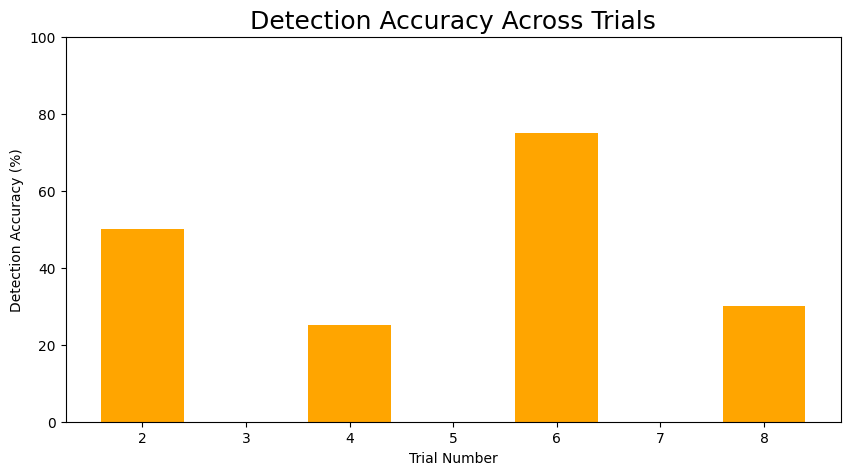

In [ ]:
import matplotlib.pyplot as plt

# Approximated data from the original image
trial_numbers = [2, 4, 6, 8]
detection_accuracies = [50, 25, 75, 30]  # These values are estimated from the image

# Set the size of the figure and the font size of the title
plt.figure(figsize=(10, 5))
plt.bar(trial_numbers, detection_accuracies, color='orange')
plt.title('Detection Accuracy Across Trials', fontsize=18)
plt.xlabel('Trial Number')
plt.ylabel('Detection Accuracy (%)')
plt.ylim(0, 100)
plt.show()


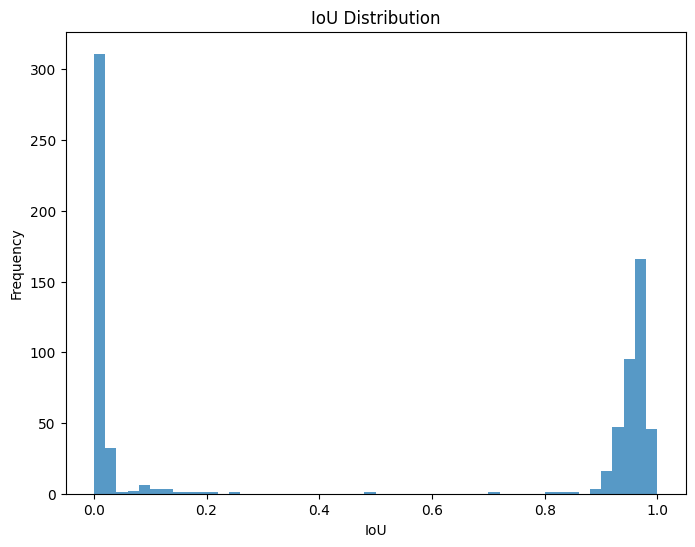

In [ ]:
# Calculate IoU values
for gt_file in gt_files:
    base = os.path.basename(gt_file)
    pred_file = os.path.join(pred_dir, base)

    gt_labels = load_labels(gt_file)
    pred_labels = load_labels(pred_file) if os.path.exists(pred_file) else []

    for pred_label in pred_labels:
        pred_box = pred_label[2]  # This should be a list of bounding box coordinates

        for gt_label in gt_labels:
            gt_box = gt_label[2]  # This should also be a list of bounding box coordinates
            iou = calculate_iou(gt_box, pred_box)
            ious.append(iou)

# Plot IoU Distribution
plt.figure(figsize=(8, 6))
plt.hist(ious, bins=50, range=(0, 1), alpha=0.75)
plt.title('IoU Distribution')
plt.xlabel('IoU')
plt.ylabel('Frequency')
plt.show()